# Preguntas


- Es porque el dataset está desbalanceado y hay muy pocas negativas.

- Read *everything* before sending over; "argumente brevemente sobre ello"

- normalization is by default l2 in tfidfvectorizer

5. No agarra ning⌂n bi ni trigrama

Proyecto 1 - Luis Eduardo Robles Jimenez

# Minería de Texto para Turismo

## Utils

In [210]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [211]:
class TouristSpot:
    def __init__(self, path, vocabSize = None):
        self.reviews = pd.read_csv(path)
        self.spotName = path.split('/')[-1][: -4]
        self.vocabSize = vocabSize
        self.vectorizer = TfidfVectorizer(min_df = 1, stop_words = ['spanish', 'english'], norm = 'l2')
        self._cleanUp()
        self.nDashes = 30

    def _cleanUp(self):
        columns = ["Título de la opinión", "Opinión"]
        for col in columns:
            desc = []
            for o in self.reviews.loc[:, col]:
                if o[0] == '"': o = o[1:]
                if o[-1] == '"': o = o[:-1]
                desc.append(o)
            self.reviews.loc[:, col] = desc

        self.reviews['Número de aportaciones'] = self.reviews['Número de aportaciones'].fillna(0)

        if self.vocabSize is not None:
            corpus = ' '.join(self.reviews.loc[:, "Opinión"])
            self.vocabulary = FreqDist(word_tokenize(corpus)).most_common(self.vocabSize)
            self.vocabulary = [word for word, _ in self.vocabulary]

            def useTopWords(text):
                words = word_tokenize(text)
                return ' '.join([word if word in self.vocabulary else '<unk>' for word in words])

            self.reviews["Opinión"] = self.reviews["Opinión"].apply(useTopWords)

    def topKwordcloud(self, k = 50):
        print(f"{'-' * self.nDashes} {self.spotName} {'-' * self.nDashes}")
        bow = self.vectorizer.fit_transform(self.reviews["Opinión"])
        words = self.vectorizer.get_feature_names_out()

        feats = SelectKBest(chi2, k = k)
        #feats.fit(bow, self.reviews['Escala']) # Doesn't work that well because it's unbalanced
        feats.fit(bow, self.reviews['Número de aportaciones']) # Considers how verbose the author is
        best = feats.get_support(indices = True)
        words = ' '.join(words[best])

        self._wordcloud(words)

    def negativeWordcloud(self, k = 50):
        print(f"{'-' * self.nDashes} {self.spotName} {'-' * self.nDashes}")
        subgroup = self.reviews.loc[self.reviews.loc[:, 'Escala'] < 3]
        bow = self.vectorizer.fit_transform(subgroup.loc[:, "Opinión"])
        words = self.vectorizer.get_feature_names_out()

        feats = SelectKBest(chi2, k = np.min((k, bow.shape[1])))
        feats.fit(bow, subgroup['Escala'])
        best = feats.get_support(indices = True)
        words = ' '.join(words[best])

        self._wordcloud(words)

    def _wordcloud(self, words, freqs = False):
        if freqs: wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate_from_frequencies(words)
        else: wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate(words)
        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()

    def LSA(self):
        print(f'{"-" * self.nDashes} {self.spotName} {"-" * self.nDashes}')

        subgroups = {}
        subgroups['Hombres'] = self.reviews.loc[self.reviews.loc[:, 'Género'] == 'Masculino']
        subgroups['Mujeres'] = self.reviews.loc[self.reviews.loc[:, 'Género'] == 'Femenino']
        subgroups['Turistas Nacionales'] = self.reviews.loc[self.reviews.loc[:, 'Nacional ó Internacional'] == 'Nacional']
        subgroups['Turistas Internacionales'] = self.reviews.loc[self.reviews.loc[:, 'Nacional ó Internacional'] == 'Internacional']
        subgroups['Jovenes (10, 30)'] = self.reviews.loc[np.logical_and(self.reviews.loc[:, 'Edad'] > 0, self.reviews.loc[:, 'Edad'] < 30)]
        subgroups['Mayores (60, 100)'] = self.reviews.loc[np.logical_and(self.reviews.loc[:, 'Edad'] > 60, self.reviews.loc[:, 'Edad'] < 100)]

        for sName in subgroups:
            s = subgroups[sName]
            print(f'Subgroup: {sName}')
            bow = self.vectorizer.fit_transform(s.loc[:, 'Opinión'])
            #bow = preprocessing.normalize(bow, norm = 'l2')
            dictionary = self.vectorizer.get_feature_names_out()
            svd = TruncatedSVD(n_components = 3)
            lsa = svd.fit_transform(bow)

            for comp in svd.components_:
                sortedComp = np.argsort(np.abs(comp))[::-1]
                comp = comp[sortedComp]
                dictionary = dictionary[sortedComp]
                for term in dictionary[:10]: print(f'{term}', end = " ")
                print()
            print()

    def ngramsAnalysis(self):
        print(f'{"-" * self.nDashes} {self.spotName} {"-" * self.nDashes}')

        unigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 1000, ngram_range = (1, 1))
        bigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 2000, ngram_range = (2, 2))
        trigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 1000, ngram_range = (3, 3))
        uni = np.array(unigrams.fit_transform(self.reviews["Opinión"]).todense())
        bi = np.array(bigrams.fit_transform(self.reviews["Opinión"]).todense())
        tri = np.array(trigrams.fit_transform(self.reviews["Opinión"]).todense())
        unis, bis, tris = unigrams.get_feature_names_out(), bigrams.get_feature_names_out(), trigrams.get_feature_names_out()
        bow = np.hstack((uni, bi, tri))
        words = np.hstack((unis, bis, tris))

        feats = SelectKBest(chi2, k = 1000)
        feats.fit(bow, self.reviews['Escala'])
        best = feats.scores_[feats.get_support(indices = True)]
        best = np.argsort(best)[-50:] # Get the top 50 out of 1000. It takes only unigrams
        ngrams = words[best]
        ngrams = {x: i for i, x in enumerate(ngrams)}
        self._wordcloud(ngrams, True)

    def temporalAnalysis(self):
        self.reviews['newDate'] = ['/'.join(date.split('/')[1:]) for date in self.reviews.loc[:, 'Fecha']]

        dates = []
        bad, neutral, good, total = [], [], [], []
        for groupName, reviewsGroup in self.reviews.groupby('newDate'):
            dates.append(groupName)
            bad.append(np.sum(reviewsGroup.loc[:, 'Escala'] < 3))
            neutral.append(np.sum(reviewsGroup.loc[:, 'Escala'] == 3))
            good.append(np.sum(reviewsGroup.loc[:, 'Escala'] > 3))

        grades = np.array(bad) + np.array(neutral) + np.array(good)
        bad =       np.array(bad)       / grades * 100
        neutral =   np.array(neutral)   / grades * 100
        good =      np.array(good)      / grades * 100

        argsort = np.argsort([datetime.strptime(date, '%m/%y' if len(date) == 5 else '%m/%Y') for date in dates])[::-1]
        dates =     np.array([dates[i] for i in argsort])
        bad =       np.array([bad[i] for i in argsort])
        neutral =   np.array([neutral[i] for i in argsort])
        good =      np.array([good[i] for i in argsort])

        _, stackedChart = plt.subplots(figsize = (15, 15))
        stackedChart.barh(dates, good, label='Good reviews', color = '#00ff00')
        stackedChart.barh(dates, neutral, left = good, label='Neutral reviews', color = '#ffff00')
        stackedChart.barh(dates, bad, left = good + neutral, label='Bad reviews', color = '#ff0000')
        stackedChart.legend()
        stackedChart.set_title(f'Reviews of {self.spotName} by month')
        plt.show()

    def describe(self):
        nRows, nCols = 2, 1
        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace = 0.5)

        print(self.nDashes * '-', self.spotName, self.nDashes * '-')

        grades = fig.add_subplot(321)
        avg = np.round(np.average(self.reviews.loc[:, 'Escala']), decimals = 2)
        sd = np.round(np.std(self.reviews.loc[:, 'Escala']), decimals = 2)
        grades.hist(self.reviews.loc[:, 'Escala'])
        grades.set_title(f"Grades (1 worst; 5 best); Average = {avg}; SD = {sd}")

        length = fig.add_subplot(322)
        lenOpinions = [len(word_tokenize(o)) for o in self.reviews.loc[:, 'Opinión']]
        avg = np.round(np.average(lenOpinions), decimals = 2)
        sd = np.round(np.std(lenOpinions), decimals = 2)
        length.hist(lenOpinions)
        length.set_title(f"Length of opinions (words); Average = {avg}; SD = {sd}")

        ages = fig.add_subplot(323)
        ages.hist(self.reviews.loc[:, 'Edad'], bins = 10)
        ages.set_title(f'Ages distribution')

        visitors = fig.add_subplot(324)
        visitors.hist(self.reviews.loc[:, 'Nacional ó Internacional'])
        visitors.set_title('Local or foreigner')

        monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        popularity = fig.add_subplot(325)
        months = [int(d.split('/')[1]) for d in self.reviews.loc[:, 'Fecha']]
        m, c = np.unique(months, return_counts = True)
        popularity.bar(m, c)
        popularity.set_title('Popularity by month')
        popularity.set_xticks(np.arange(1, len(m) + 1), labels = monthNames)

        languages = fig.add_subplot(326)
        m, c = np.unique(self.reviews.loc[:, 'Idioma'], return_counts = True)
        languages.barh(m, c)
        languages.set_title('Language')

        plt.show()

## Actividades

In [212]:
path = "../../data/guanajuato/"
spots = [TouristSpot(os.path.join(path, d), vocabSize = 10000) for d in os.listdir(path)]
#spots = [TouristSpot(os.path.join(path, d), vocabSize = None) for d in os.listdir(path)]

In [213]:
for spot in spots: 
    break
    spot.describe()
    continue

In [214]:
for spot in spots: 
    break
    spot.topKwordcloud()
    continue

In [215]:
for spot in spots: 
    break
    spot.negativeWordcloud()
    continue 

In [216]:
for spot in spots: 
    break
    spot.LSA()
    continue

------------------------------ Teatro Juárez ------------------------------


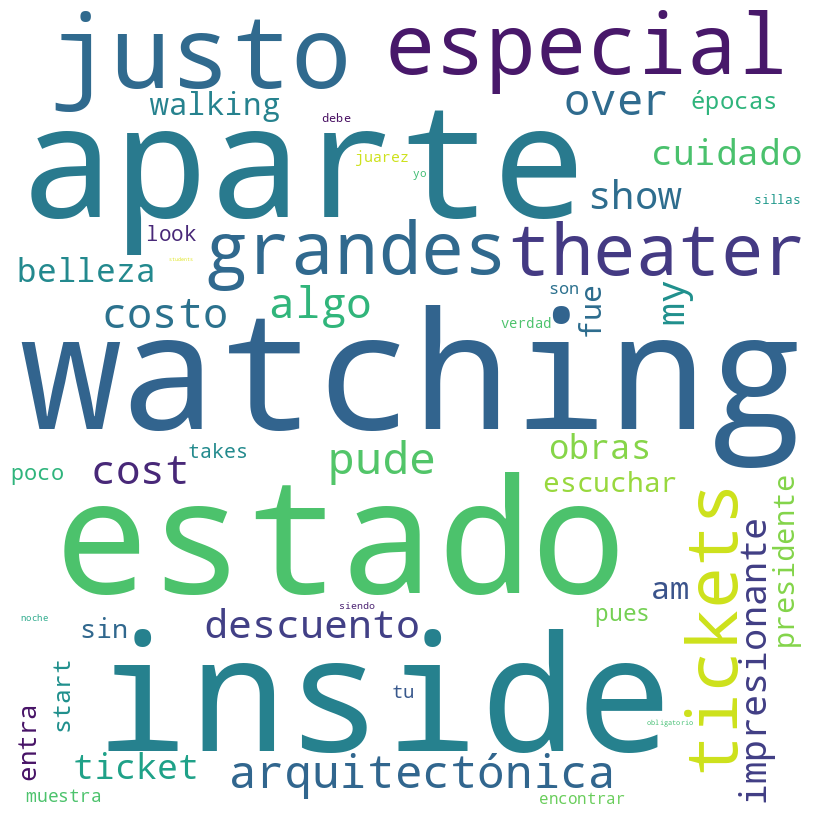

In [217]:
for spot in spots: 
    spot.ngramsAnalysis()
    break
    continue

In [218]:
for spot in spots: 
    break
    spot.temporalAnalysis()
    continue

## Preguntas

**1. (10pts) ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de
ello?**

**2. (10pts) En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre
turistas nacionales e internacionales?**

**3. (10pts) ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?**

**4. (10pts) ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?**

**5. (10pts) ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)**